Webpage: https://climada-python.readthedocs.io/en/stable/tutorial/climada_engine_Impact.html

# Define the Exposure

In [2]:
# Exposure from the module Litpop
# Note that the file gpw_v4_population_count_rev11_2015_30_sec.tif must be downloaded (do not forget to unzip) if
# you want to execute this cell on your computer. If you haven't downloaded it before, please have a look at the section
# "population count" of the LitPop tutorial.

%matplotlib inline
import numpy as np
from climada.entity import LitPop

# Cuba with resolution 10km and financial_mode = income group.
exp_lp = LitPop.from_countries(countries=['CUB'], res_arcsec=300, fin_mode='income_group')
exp_lp.check()

2024-08-14 10:00:52,203 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-08-14 10:00:52,244 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-08-14 10:00:52,330 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-08-14 10:00:52,461 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-08-14 10:00:52,509 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-08-14 10:00:52,562 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-08-14 10:00:52,669 - climada.entity.exposures.litpop.gpw_populati

In [3]:
exp_lp.gdf.head()

,value,latitude,longitude,geometry,region_id,impf_
0,1.077368e+05,21.708333,-81.375000,POINT (-81.37500 21.70833),192,1
1,1.671874e+06,21.625000,-81.541667,POINT (-81.54167 21.62500),192,1
2,3.421209e+06,21.875000,-82.958333,POINT (-82.95833 21.87500),192,1
3,1.546590e+07,21.875000,-82.875000,POINT (-82.87500 21.87500),192,1
4,7.168308e+07,21.875000,-82.791667,POINT (-82.79167 21.87500),192,1


/Users/arnaudgoussebaile/miniconda3/envs/climada_env/lib/python3.9/site-packages/climada/util/coordinates.py:2489: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  df_poly['geometry'] = apply_box(points_df)



 Raster properties exposures: {'width': 129, 'height': 41, 'crs': <Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
, 'transform': Affine(0.08333333000000209, 0.0, -84.91666666500001,
       0.0, -0.08333332999999854, 23.249999994999996)}


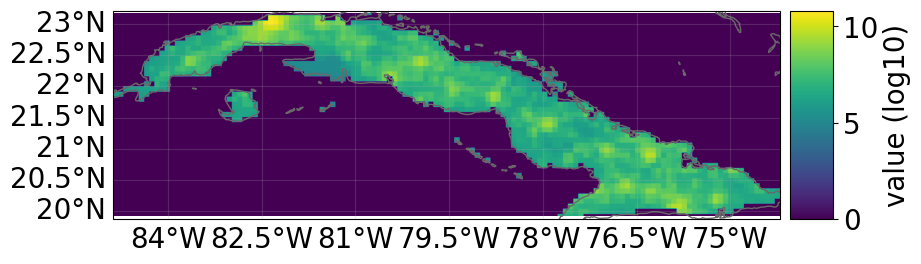

In [4]:
# not needed for impact calculations
# visualize the define exposure
exp_lp.plot_raster()
print('\n Raster properties exposures:', exp_lp.meta)

# Define the Hazard

In [5]:
from climada.hazard import TCTracks, TropCyclone, Centroids

# Load histrocial tropical cyclone tracks from ibtracs over the North Atlantic basin between 2010-2012
ibtracks_na = TCTracks.from_ibtracs_netcdf(provider='usa', basin='NA', year_range=(2010, 2012), correct_pres=True)
print('num tracks hist:', ibtracks_na.size)

ibtracks_na.equal_timestep(0.5)  # Interpolation to make the track smooth and to allow applying calc_perturbed_trajectories
# Add randomly generated tracks using the calc_perturbed_trajectories method (1 per historical track)
ibtracks_na.calc_perturbed_trajectories(nb_synth_tracks=1)
print('num tracks hist+syn:', ibtracks_na.size)

2024-08-14 10:01:06,069 - climada.hazard.tc_tracks - WARNING - `correct_pres` is deprecated. Use `estimate_missing` instead.
2024-08-14 10:01:07,058 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /Users/arnaudgoussebaile/climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


/Users/arnaudgoussebaile/miniconda3/envs/climada_env/lib/python3.9/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/Users/arnaudgoussebaile/miniconda3/envs/climada_env/lib/python3.9/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


num tracks hist: 60
num tracks hist+syn: 120


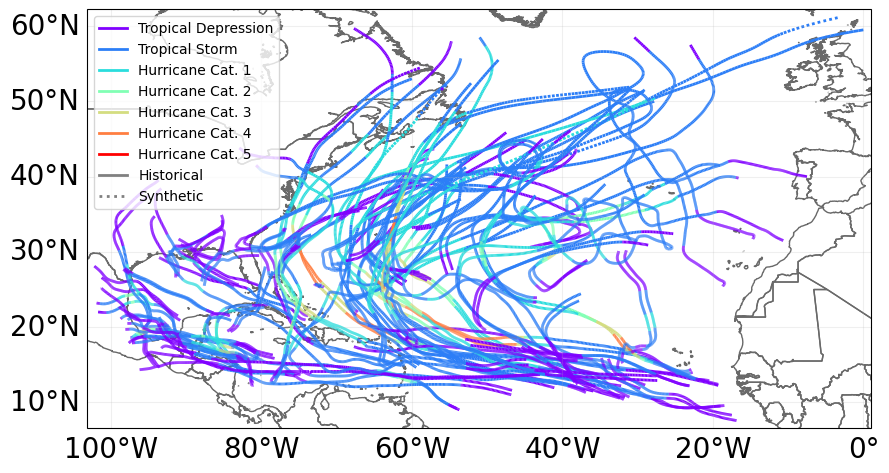

In [6]:
# not needed for calculations
# visualize tracks
ax = ibtracks_na.plot()
ax.get_legend()._loc = 2

In [7]:
#Hint: computing the wind speeds in many locations for many tc tracks is a computationally costly operation. 
# Thus, we should define centroids only where we also have an exposure.
# Define the centroids from the exposures position
lat = exp_lp.gdf['latitude'].values
lon = exp_lp.gdf['longitude'].values
centrs = Centroids.from_lat_lon(lat, lon)
centrs.check()

In [8]:
# Using the tracks, compute the windspeed at the location of the centroids
tc = TropCyclone.from_tracks(ibtracks_na, centroids=centrs)
tc.check()

# Impact function

In [9]:
from climada.entity import ImpactFuncSet, ImpfTropCyclone
# impact function TC
impf_tc = ImpfTropCyclone.from_emanuel_usa()

# add the impact function to an Impact function set
impf_set = ImpactFuncSet([impf_tc])
impf_set.check()

Recall that the exposures, hazards and impact functions must be matched in the impact calculations. Here it is simple, since there is a single impact function for all the hazards. We must simply make sure that the exposure is assigned this impact function through renaming the impf\_ column from the hazard type of the impact function in the impact function set and set the values of the column to the id of the impact function.

In [10]:
# Get the hazard type and hazard id
[haz_type] = impf_set.get_hazard_types()
[haz_id] = impf_set.get_ids()[haz_type]
print(f"hazard type: {haz_type}, hazard id: {haz_id}")

hazard type: TC, hazard id: 1


In [11]:
# Exposures: rename column and assign id
exp_lp.gdf.rename(columns={"impf_": "impf_" + haz_type}, inplace=True)
exp_lp.gdf['impf_' + haz_type] = haz_id
exp_lp.check()
exp_lp.gdf.head()

,value,latitude,longitude,geometry,region_id,impf_TC
0,1.077368e+05,21.708333,-81.375000,POINT (-81.37500 21.70833),192,1
1,1.671874e+06,21.625000,-81.541667,POINT (-81.54167 21.62500),192,1
2,3.421209e+06,21.875000,-82.958333,POINT (-82.95833 21.87500),192,1
3,1.546590e+07,21.875000,-82.875000,POINT (-82.87500 21.87500),192,1
4,7.168308e+07,21.875000,-82.791667,POINT (-82.79167 21.87500),192,1


# Impact computation

Note: we did not define an Entity in this impact calculations. Recall that Entity is a container class for Exposures, Impact Functions, Discount Rates and Measures. Since we had only one Exposure and one Impact Function, the container would not have added any value, but for more complex projects, the Entity class is very useful.

In [12]:
# Compute impact
from climada.engine import ImpactCalc
imp = ImpactCalc(exp_lp, impf_set, tc).impact(save_mat=False)  # Do not save the results geographically resolved (only aggregate values)

In [13]:
print(f"Aggregated average annual impact: {round(imp.aai_agg,0)} $")

Aggregated average annual impact: 563366428.0 $


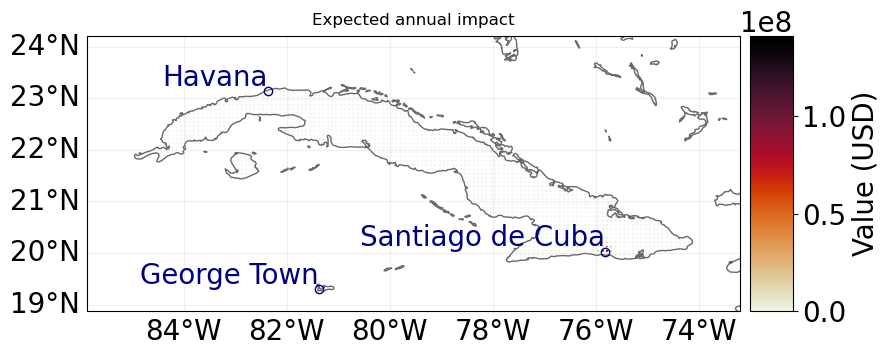

In [14]:
imp.plot_hexbin_eai_exposure(buffer=1);

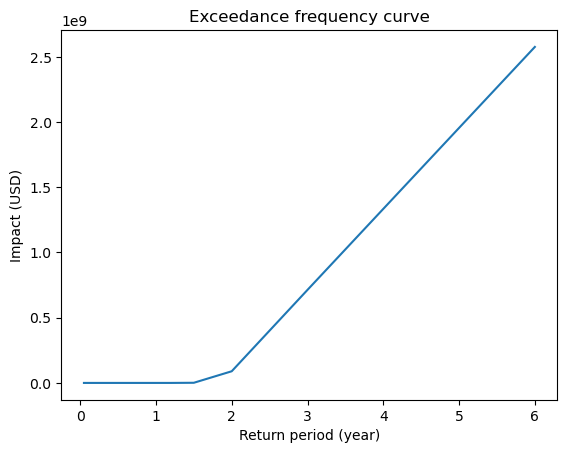

In [15]:
# Compute exceedance frequency curve
freq_curve = imp.calc_freq_curve()
freq_curve.plot();